# ArXiv Metadata

**The goal of this notebook is to explore the metadata and save a relevant subset of the data so we have a manageable dataset to work with.**

We have a lot of data in the arXiv dataset. We need a subset of data to run experiments on. We will start by looking at the metadata of the arXiv papers. The metadata is in a json file, where each line is a json object. We need to rely on command line tools to get a sense of the data, and using pandas and CLI are both very slow. **The solution is embeddings.** But before we can generate them we need a nice manageable subset of the data to work with.

In [1]:
from os.path import expanduser
import pandas as pd

In [2]:
# The first line of the file, pretty print with jq
! head -n1 ~/data/arxiv_snapshot/arxiv-metadata-oai-snapshot.json | jq

{
  "id": "0704.0001",
  "submitter": "Pavel Nadolsky",
  "authors": "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  "title": "Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies",
  "comments": "37 pages, 15 figures; published version",
  "journal-ref": "Phys.Rev.D76:013009,2007",
  "doi": "10.1103/PhysRevD.76.013009",
  "report-no": "ANL-HEP-PR-07-12",
  "categories": "hep-ph",
  "license": null,
  "abstract": "  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with

In [3]:
# Read the file into a pandas dataframe, lines=True because each line is a json object.
df = pd.read_json(expanduser('~/data/arxiv_snapshot/arxiv-metadata-oai-snapshot.json'), lines=True)

In [4]:
df.shape

(2481654, 14)

In [5]:
df.columns

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')

In [13]:
# Number of distinct categories
df['categories'].nunique()

# Top N categories
N = 10
df['categories'].value_counts().head(N)

categories
astro-ph             86911
hep-ph               81065
quant-ph             68714
hep-th               58745
cs.CV                57390
cond-mat.mtrl-sci    39224
cond-mat.mes-hall    34860
math.AP              33988
astro-ph.GA          30470
gr-qc                30453
Name: count, dtype: int64

- We don't really care about astro physics, we are interested in machine learning and language models.
- Let's see how many papers have these terms in the title.

In [14]:
# Number of papers with the term "machine learning" or "LLMs" in the title
! jq -r '.title' ~/data/arxiv_snapshot/arxiv-metadata-oai-snapshot.json | grep -iE 'machine learning|LLMs' | wc -l

   12476


# Subsetting the data

Let's create a subset of papers to experiment on, we will search abstracts for these terms:
- machine learning
- LLMs
- deep learning
- neural networks
- language models

In [26]:
# Select subset that matches the terms in the title, check how many lines we have:
! jq -r '.title' ~/data/arxiv_snapshot/arxiv-metadata-oai-snapshot.json | grep -iE 'machine learning|LLMs|deep learning|neural networks|language models|artificial intelligence' | wc -l

   48545


In [43]:
# Sanity check using pandas
subset = df[df['title'].str.contains('machine learning|LLMs|LLM|deep learning|neural networks|language models|artificial intelligence', case=False)]

In [44]:
# Nice, we have a subset of 48k papers, weird that the `jq` command gave a slightly different number.
subset.shape

(50318, 14)

In [45]:
# Number of distinct categories
subset['categories'].nunique()

7297

In [46]:
# Top N categories of our subset
subset['categories'].value_counts().head(N)

categories
cs.CV                2800
cs.CL                2675
cs.LG                2233
cs.LG stat.ML        1750
cs.CL cs.AI          1462
cs.LG cs.AI          1176
stat.ML cs.LG         612
cs.CL cs.AI cs.LG     599
cs.AI                 598
cs.CL cs.LG           598
Name: count, dtype: int64

In [47]:
# Lets look at some of the titles in our subset
subset['title'].sample(12)

1162356    Towards Deep Learning-Based EEG Electrode Dete...
1652496    M6-Rec: Generative Pretrained Language Models ...
1163547    Resonant Machine Learning Based on Complex Gro...
914128     Pseudo Dual Energy CT Imaging using Deep Learn...
1937838    Deep ReLU neural networks overcome the curse o...
2055302    Melting Temperature of Iron Under the Earth's ...
1629038    Enabling Trade-offs in Machine Learning-based ...
1174340           Multimodal Embeddings from Language Models
1532423                       Polytopes and Machine Learning
1323989    Predicting and Mapping of Soil Organic Carbon ...
1647502    PTFlash : A deep learning framework for isothe...
1916656      Knowledge Sanitization of Large Language Models
Name: title, dtype: object

In [48]:
# Save the subset to a json file
subset.to_json(expanduser('~/data/arxiv_snapshot/arxiv-metadata-oai-snapshot-subset.json'), orient='records', lines=True)

In [49]:
# Test: load the subset from the file
df_subset = pd.read_json(expanduser('~/data/arxiv_snapshot/arxiv-metadata-oai-snapshot-subset.json'), lines=True)

In [53]:
df_subset.sample(1).T

,15741
id,2007.01857
submitter,Dalcimar Casanova
authors,Muriel Mazzetto and Marcelo Teixeira and \'Eri...
title,Deep Learning Models for Visual Inspection on ...
comments,arXiv admin note: text overlap with arXiv:1802...
journal-ref,International Journal of Advanced Engineering ...
doi,10.22161/ijaers.74.56
report-no,None
categories,cs.CV eess.IV
license,http://creativecommons.org/licenses/by-nc-sa/4.0/


In [54]:
# Check for nulls, everything is fine.
df_subset.isna().sum()

id                    0
submitter            11
authors               0
title                 0
comments          21366
journal-ref       43883
doi               39898
report-no         49572
categories            0
license             382
abstract              0
versions              0
update_date           0
authors_parsed        0
dtype: int64

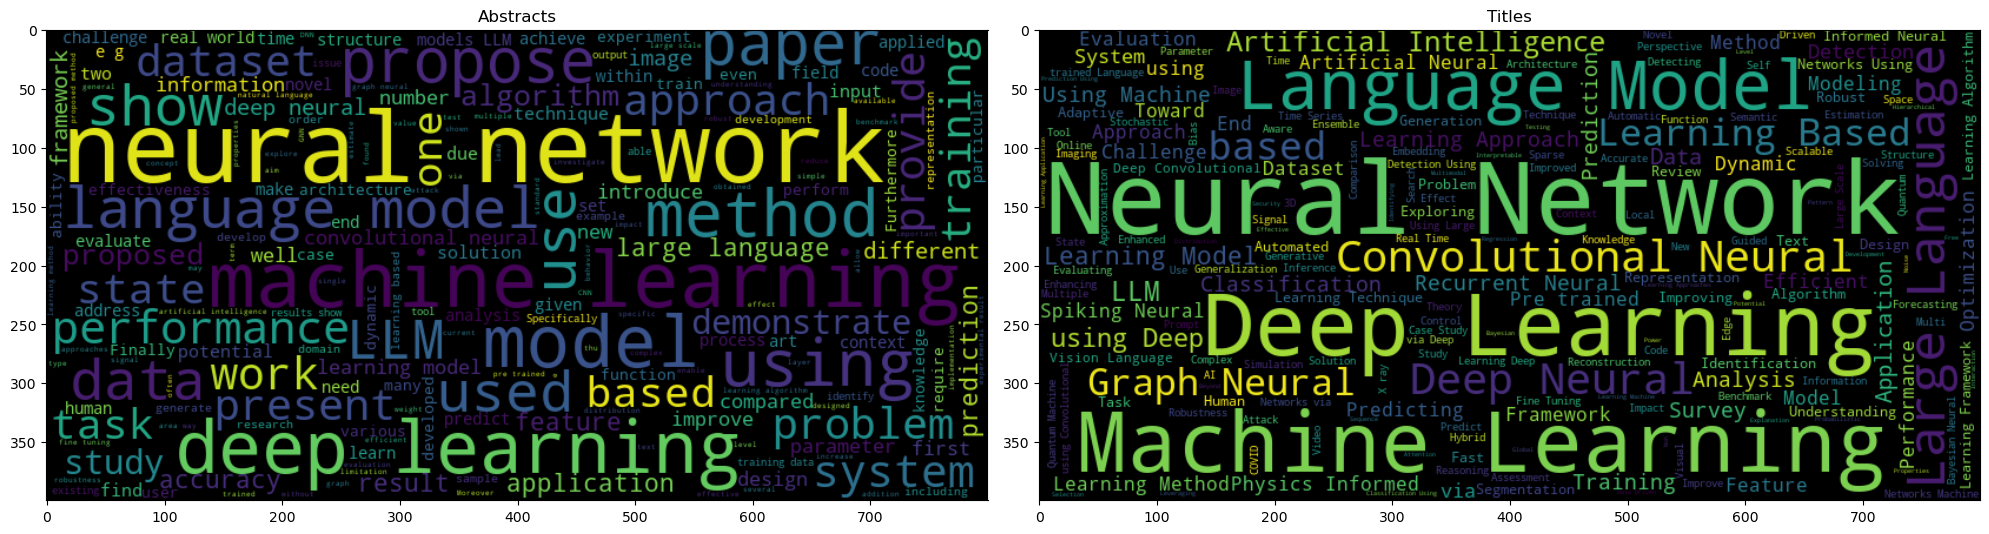

In [59]:
# Quick little word cloud to see what the most common words are in the titles / abstracts
from wordcloud import WordCloud
import matplotlib.pyplot as plt

titles = ' '.join(df_subset['title'])
abstracts = ' '.join(df_subset['abstract'])

wordcloud_abstracts = WordCloud(width=800, height=400).generate(abstracts)
wordcloud_titles = WordCloud(width=800, height=400).generate(titles)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(wordcloud_abstracts, interpolation='bilinear')
ax[0].set_title('Abstracts')

ax[1].imshow(wordcloud_titles, interpolation='bilinear')
ax[1].set_title('Titles')

plt.tight_layout()
plt.show();

In [ ]:
# 